_Version log: Finding the best samples though brute force and manual tweaking. Also started to compare different optimisation results._

In [1]:
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt, lines as mpllines
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
exp_sensors = [12, 14, 16, 29, 31, 32, 42,  4]
regularization_coeffient = 1e-3
pixel_pitch = 1 #mm
theta = 200

experiment, _ = cs.open_dataset("240802134128_processed1d", ".csv")
experiment /= np.max(experiment)
simulation, _ = cs.open_dataset("1dmockanderrors22", ".csv")
simulation /= np.max(simulation)
total_points = len(simulation)

freqs = np.fft.rfftfreq(total_points, pixel_pitch*1e-3)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

In [3]:
sim_sensors = exp_sensors -np.argmax(experiment) +np.argmax(simulation) #recenter
sim_sensors = sim_sensors %total_points #wrap around

samples = np.full_like(experiment, np.nan)
samples[exp_sensors] = experiment[exp_sensors]
cs_result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "IDCT")
cs_spectrum = np.abs(np.fft.rfft(cs_result, norm= "forward"))
exp_spectrum = np.abs(np.fft.rfft(experiment, norm= "forward"))
sim_spectrum = np.abs(np.fft.rfft(simulation, norm= "forward"))

idx = np.arange(total_points)
sim_displacement = pixel_pitch *(idx -np.argmax(simulation)) # in mm
sim_path_difference = 2*sim_displacement*np.sin(np.deg2rad(theta/60))
exp_displacement = pixel_pitch *(idx -np.argmax(experiment)) # in mm
exp_path_difference = 2*exp_displacement*np.sin(np.deg2rad(theta/60))

53 530
53 530
53 530
53 530
53 530
53 530
53 530
53 530
27 270
27 270
27 270
27 270


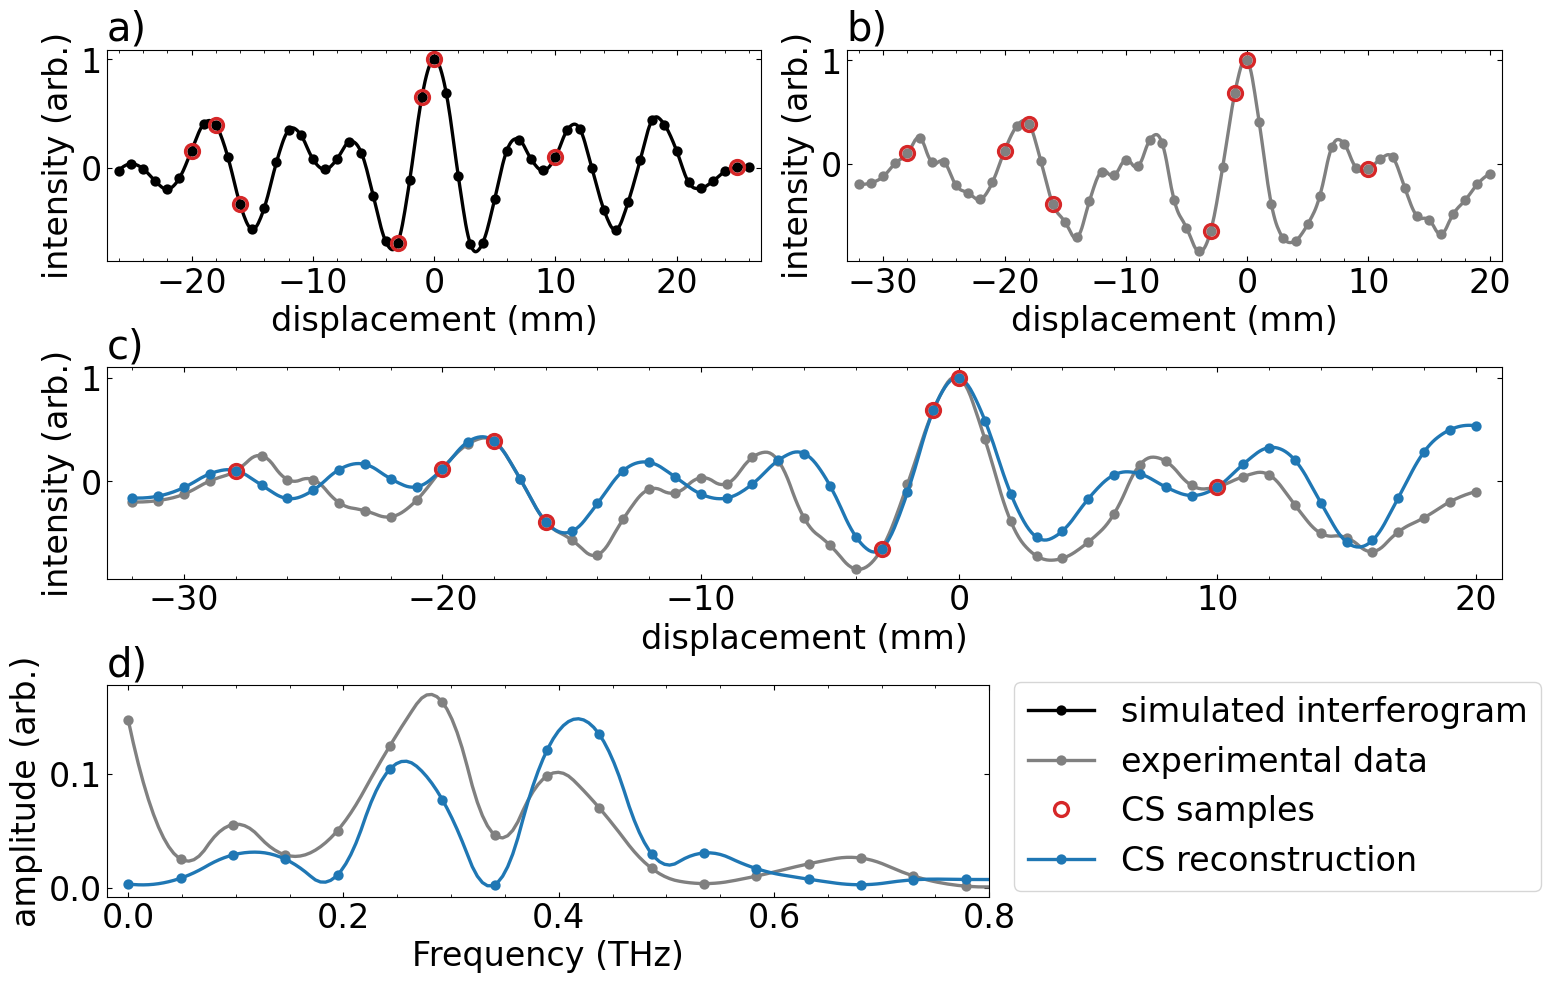

In [4]:
axs_mosaic = [["a)", "a)", "b)", "b)"],
              ["c)", "c)", "c)", "c)"],
              ["d)", "d)", "d)", ""]]

fig, axs = plt.subplot_mosaic(axs_mosaic, figsize= (18,11), gridspec_kw= {"hspace": 0.5, "wspace": 0.3}, width_ratios= [3, 1, 1, 3])
[ax.set_title(label, loc='left') for label, ax in axs.items()]

axs["a)"].plot(cs.interpolate(sim_displacement), cs.interpolate(simulation), color= "black", label= "smoothed model")
axs["a)"].plot(sim_displacement, simulation, color= "black", linestyle= "none", marker= ".", label= "model interferogram")
axs["a)"].plot(sim_displacement[sim_sensors], simulation[sim_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
axs["a)"].set(xlabel= "displacement (mm)", ylabel= "intensity (arb.)", xlim= (sim_displacement[0]-pixel_pitch, sim_displacement[-1]+pixel_pitch))

axs["b)"].plot(cs.interpolate(exp_displacement), cs.interpolate(experiment), color= "gray")
axs["b)"].plot(exp_displacement, experiment, color= "gray", linestyle= "none", marker= ".")
axs["b)"].plot(exp_displacement[exp_sensors], experiment[exp_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
axs["b)"].set(xlabel= "displacement (mm)", ylabel= "intensity (arb.)", xlim= (exp_displacement[0]-pixel_pitch, exp_displacement[-1]+pixel_pitch))

axs["c)"].plot(cs.interpolate(exp_displacement), cs.interpolate(experiment), color= "gray", label= "smoothed data")
axs["c)"].plot(exp_displacement, experiment, color= "gray", linestyle= "none", marker= ".", label= "experimental data")
axs["c)"].plot(cs.interpolate(exp_displacement), cs.interpolate(cs_result), color= "tab:blue", label= "smoothed reconstuction")
axs["c)"].plot(exp_displacement, cs_result, color= "tab:blue", linestyle= "none", marker= ".", label= "CS reconstruction")
axs["c)"].plot(exp_displacement[exp_sensors], experiment[exp_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red", label= "CS samples")
axs["c)"].set(xlabel= "displacement (mm)", ylabel= "intensity (arb.)", xlim= (exp_displacement[0]-pixel_pitch, exp_displacement[-1]+pixel_pitch))

axs["d)"].plot(cs.interpolate(freqs), cs.interpolate(np.abs(exp_spectrum)), color= "gray")
axs["d)"].plot(freqs, np.abs(exp_spectrum), color= "gray", linestyle= "none", marker= ".")
axs["d)"].plot(cs.interpolate(freqs), cs.interpolate(np.abs(cs_spectrum)), color= "tab:blue")
axs["d)"].plot(freqs, np.abs(cs_spectrum), color= "tab:blue", linestyle= "none", marker= ".", label= "")
axs["d)"].set(xlabel= "Frequency (THz)", ylabel= "amplitude (arb.)", xlim= (-0.02, 0.8))

axs[""].set_axis_off()

legend_elements = [mpllines.Line2D([0], [0], color= "black", marker= ".", label= "simulated interferogram"),
                   mpllines.Line2D([0], [0], color= "gray", marker= ".", label= "experimental data"),
                   mpllines.Line2D([0], [0], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red", label= "CS samples"),
                   mpllines.Line2D([0], [0], color= "tab:blue", marker= ".", label= "CS reconstruction")]

plt.figlegend(handles=legend_elements, loc= "lower left", bbox_to_anchor= (0.62, 0.10))
plt.show()

27 270
27 270
53 530
53 530
53 530
53 530


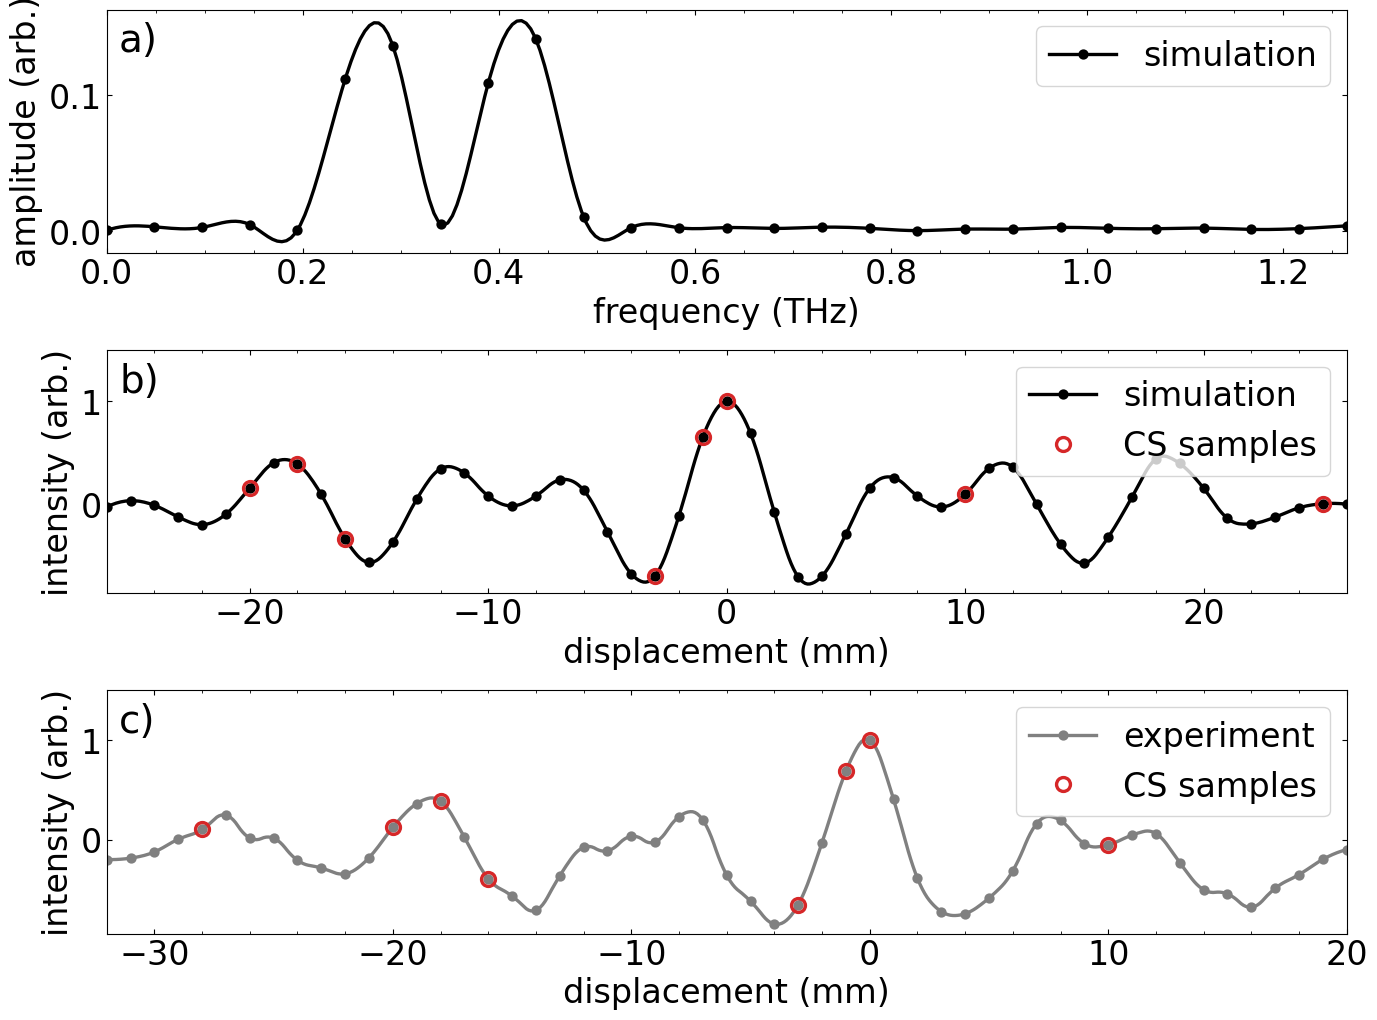

In [59]:
fig, axs = plt.subplots(3,1, figsize= (16,12), gridspec_kw={"hspace": 0.4})

axs[0].plot(freqs, sim_spectrum, color= "k", marker= ".", linestyle= "none")
axs[0].plot(cs.interpolate(freqs), cs.interpolate(sim_spectrum, method= "cubic"), color= "k")
axs[0].set(ylabel= "amplitude (arb.)", xlabel= "frequency (THz)", xlim= (freqs.min(), freqs.max()))
axs[0].annotate("a)", (0.01,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)

legend_elements = [mpllines.Line2D([0], [0], color= "black", marker= ".", label= "simulation")]
axs[0].legend(handles=legend_elements, loc= "upper right")

axs[1].plot(sim_displacement, simulation, color= "k", marker= ".", linestyle= "none")
axs[1].plot(cs.interpolate(sim_displacement), cs.interpolate(simulation), color= "k")
axs[1].plot(sim_displacement[sim_sensors], simulation[sim_sensors], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none")
axs[1].set(ylabel= "intensity (arb.)", xlabel= "displacement (mm)", xlim= (sim_displacement.min(), sim_displacement.max()), ylim= (None, simulation.max() +0.5))
axs[1].annotate("b)", (0.01,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)

legend_elements = [mpllines.Line2D([0], [0], color= "black", marker= ".", label= "simulation"),
                   mpllines.Line2D([0], [0], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none", label= "CS samples")]
axs[1].legend(handles=legend_elements, loc= "upper right")

axs[2].plot(exp_displacement, experiment, color= "grey", marker= ".", linestyle= "none")
axs[2].plot(cs.interpolate(exp_displacement), cs.interpolate(experiment), color= "grey")
axs[2].plot(exp_displacement[exp_sensors], experiment[exp_sensors], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none")
axs[2].set(ylabel= "intensity (arb.)", xlabel= "displacement (mm)", xlim= (exp_displacement.min(), exp_displacement.max()), ylim= (None, experiment.max() +0.5))
axs[2].annotate("c)", (0.01,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)

legend_elements = [mpllines.Line2D([0], [0], color= "grey", marker= ".", label= "experiment"),
                   mpllines.Line2D([0], [0], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none", label= "CS samples")]
axs[2].legend(handles=legend_elements, loc= "upper right")

plt.show()

53 530
53 530
53 530
53 530
27 270
27 270
27 270
27 270


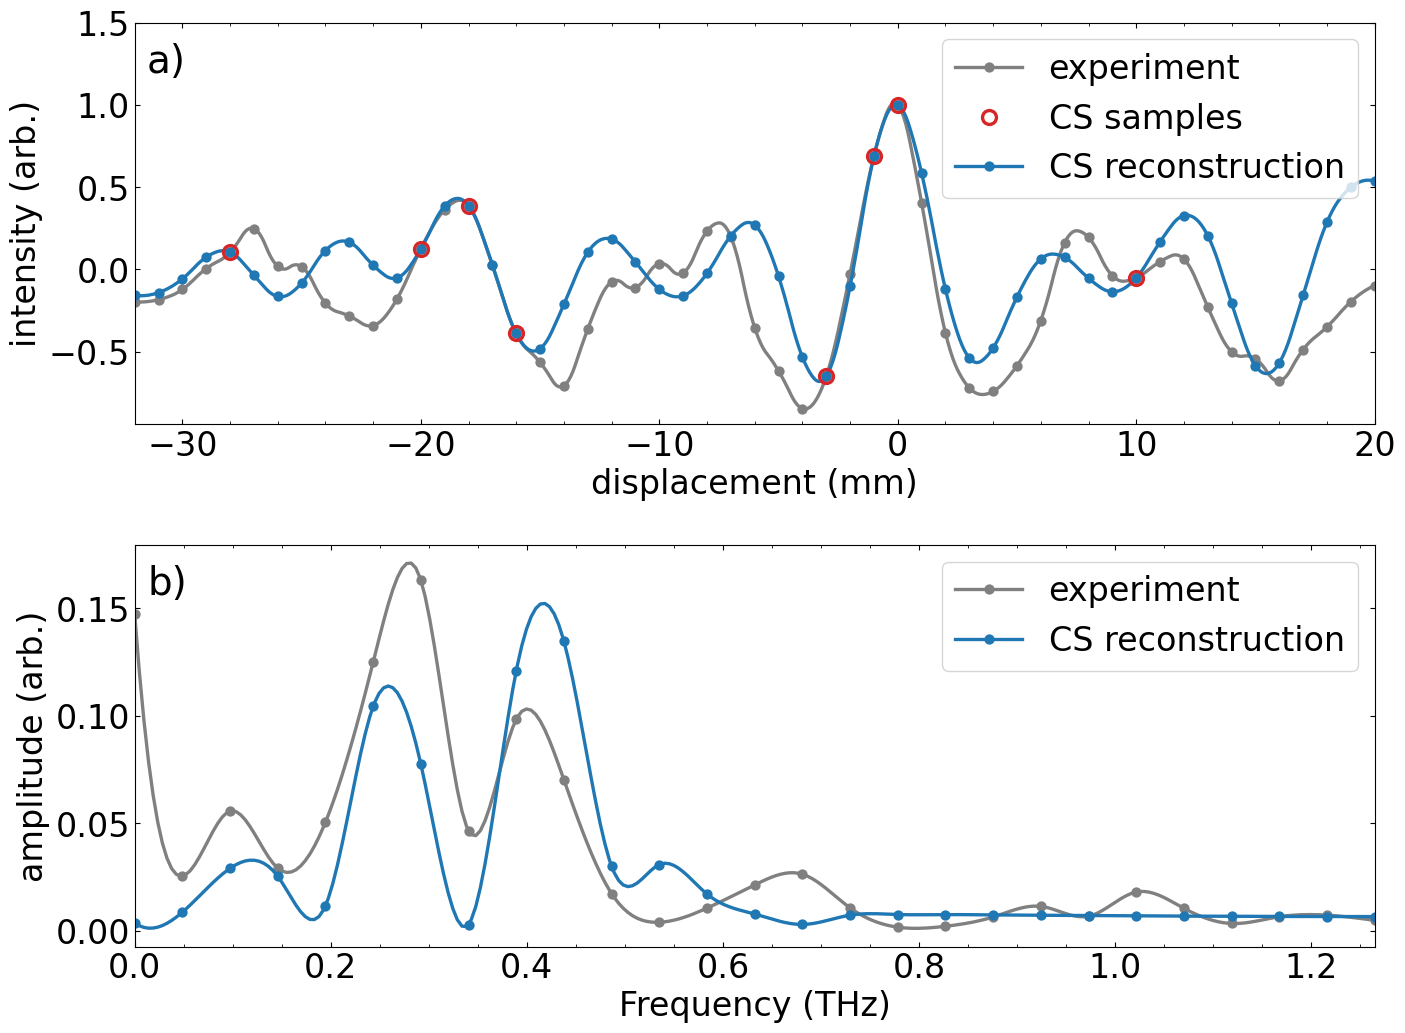

In [60]:
fig, axs = plt.subplots(2, 1, figsize= (16, 12), gridspec_kw={"hspace": 0.3})

axs[0].plot(exp_displacement, experiment, color= "grey", marker= ".", linestyle= "none")
axs[0].plot(cs.interpolate(exp_displacement), cs.interpolate(experiment), color= "grey")
axs[0].plot(exp_displacement, cs_result, color= "tab:blue", marker= ".", linestyle= "none")
axs[0].plot(cs.interpolate(exp_displacement), cs.interpolate(cs_result), color= "tab:blue")
axs[0].plot(exp_displacement[exp_sensors], experiment[exp_sensors], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none")
axs[0].set(ylabel= "intensity (arb.)", xlabel= "displacement (mm)", ylim= (None, experiment.max() +0.5), xlim= (exp_displacement.min(), exp_displacement.max()))
axs[0].annotate("a)", (0.01,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)

legend_elements = [mpllines.Line2D([0], [0], color= "grey", marker= ".", label= "experiment"),
                   mpllines.Line2D([0], [0], markeredgecolor= "tab:red", marker= "o", markerfacecolor= "none", linestyle= "none", label= "CS samples"),
                   mpllines.Line2D([0], [0], color= "tab:blue", marker= ".", label= "CS reconstruction")]
axs[0].legend(handles=legend_elements, loc= "upper right")

axs[1].plot(freqs, np.abs(exp_spectrum), color= "gray", linestyle= "none", marker= ".")
axs[1].plot(cs.interpolate(freqs), cs.interpolate(np.abs(exp_spectrum), method= "cubic"), color= "gray")
axs[1].plot(freqs, np.abs(cs_spectrum), color= "tab:blue", linestyle= "none", marker= ".")
axs[1].plot(cs.interpolate(freqs), cs.interpolate(np.abs(cs_spectrum), method= "cubic"), color= "tab:blue")
axs[1].set(xlabel= "Frequency (THz)", ylabel= "amplitude (arb.)", xlim= (freqs.min(), freqs.max()))
axs[1].annotate("b)", (0.01,0.95), xycoords= 'axes fraction', ha= "left", va= "top", fontsize= 28)

legend_elements = [mpllines.Line2D([0], [0], color= "grey", marker= ".", label= "experiment"),
                   mpllines.Line2D([0], [0], color= "tab:blue", marker= ".", label= "CS reconstruction")]
axs[1].legend(handles=legend_elements, loc= "upper right")

plt.show()